<a href="https://colab.research.google.com/github/lorenzosquadrani/convicity/blob/main/try_convicity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Libraries
We load convicity and plasticity libraries, as well as Pytorch libraries.

In [1]:
#clone convicity and plasticity repository in order to import the libraries
!git clone https://github.com/lorenzosquadrani/convicity.git
!git clone https://github.com/lorenzosquadrani/plasticity.git
!mv /content/plasticity/plasticity/__version__.py.in /content/plasticity/plasticity/__version__.py

Cloning into 'convicity'...
remote: Enumerating objects: 83, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 83 (delta 29), reused 55 (delta 14), pack-reused 0
Unpacking objects: 100% (83/83), done.
Cloning into 'plasticity'...
remote: Enumerating objects: 1430, done.
remote: Counting objects: 100% (573/573), done.
remote: Compressing objects: 100% (369/369), done.
remote: Total 1430 (delta 366), reused 376 (delta 202), pack-reused 857
Receiving objects: 100% (1430/1430), 59.47 MiB | 38.47 MiB/s, done.
Resolving deltas: 100% (911/911), done.


In [2]:
cd plasticity/

/content/plasticity


In [3]:
from convicity.cBCM.cBCM import cBCM

from plasticity.model.optimizer import SGD
from plasticity.model.weights import Normal
from convicity.cBCM.utils import view_weights

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

import numpy as np
import matplotlib.pyplot as plt


#Load the Mnist Dataset
Loading the training dataset, that was contained in convicity repository.

In [4]:
#load the data
trainset = datasets.MNIST('/content/convicity/', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))


testset  =  datasets.MNIST('/content/convicity/', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_loader = torch.utils.data.DataLoader(trainset, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=True)

# Model
Define a simple deep network (1 convolutional layer, two linear layers). 

In [5]:
class LittleNet(nn.Module):
    def __init__(self):
        super(LittleNet, self).__init__()
        self.flatten = nn.Flatten()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, stride=1, padding=0),
            nn.ReLU()
        )
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(8*24*24, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_relu_stack(x)
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

# Results using cBCM to train the convolutional layer
We first train a cBCM model and initialize the parameters of the convolutional layer. Then, by keeping convolutional fixed, we train the rest of the net using SGD.

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [7]:
def train(model, device, trainloader, optimizer, loss_function):
    model.train()
    for data, target in trainloader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, target)
        loss.backward()
        optimizer.step()
    

def test(model, device, testloader, loss_function):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_function(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    return test_loss, accuracy

In [8]:
np.random.seed(0)
torch.manual_seed(0)

In [74]:
X = np.array(trainset.data, dtype = 'float16')/255.

In [80]:
model = cBCM(	n_filters = 8, kernel_size = 5,
				num_epochs=5, batch_size = 100, activation = 'relu',
				optimizer = SGD(lr=4e-2), weights_init = Normal(), interaction_strength = -0.,
				random_state = 42, verbose = True)

model.fit(X[:1000])

  4%|▍         | 222/5760 [00:00<00:02, 2210.97it/s]

Epoch 1/5


  3%|▎         | 199/5760 [00:00<00:02, 1984.51it/s]

Epoch 2/5


  4%|▎         | 205/5760 [00:00<00:02, 2047.99it/s]

Epoch 3/5


  4%|▎         | 202/5760 [00:00<00:02, 2014.27it/s]

Epoch 4/5


  4%|▎         | 215/5760 [00:00<00:02, 2145.36it/s]

Epoch 5/5


100%|██████████| 5760/5760 [00:02<00:00, 2030.00it/s]


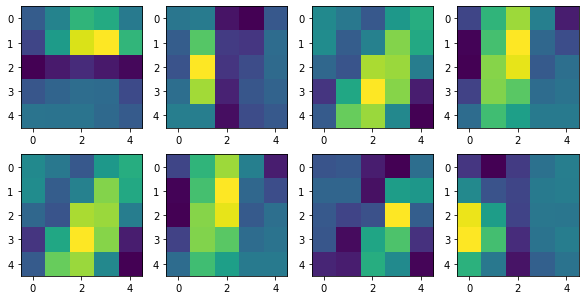

In [81]:
view_weights(model, rows = 2, cols = 4)

In [82]:
lr = 1e-3
num_epochs = 100

In [83]:
net = LittleNet().to(device)
optimizer = optim.SGD(net.parameters(), lr= lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, (40,30), gamma=0.1)
loss_function = nn.CrossEntropyLoss()

In [84]:
with torch.no_grad():
    net.conv_relu_stack[0].weight.data = torch.tensor(model.weights.reshape(8,1,5,5), device = 'cuda', dtype=torch.float32)

In [85]:
net.conv_relu_stack[0].weight.requires_grad = False

In [86]:
for epoch in range(num_epochs):
    print("Epoch %d/ %d" %(epoch,num_epochs ))
    train(net, device, train_loader, optimizer, loss_function)
    scheduler.step()
    x, y = test(net, device, test_loader, loss_function)
    print("Test Loss and Accuracy: %f, %d %%" %(x,y))

Epoch 0/ 100
Test Loss and Accuracy: 0.000421, 86 %
Epoch 1/ 100
Test Loss and Accuracy: 0.000257, 92 %
Epoch 2/ 100
Test Loss and Accuracy: 0.000207, 93 %
Epoch 3/ 100
Test Loss and Accuracy: 0.000179, 94 %
Epoch 4/ 100
Test Loss and Accuracy: 0.000169, 94 %
Epoch 5/ 100
Test Loss and Accuracy: 0.000151, 95 %
Epoch 6/ 100
Test Loss and Accuracy: 0.000141, 95 %
Epoch 7/ 100
Test Loss and Accuracy: 0.000139, 95 %
Epoch 8/ 100
Test Loss and Accuracy: 0.000128, 95 %
Epoch 9/ 100
Test Loss and Accuracy: 0.000122, 96 %
Epoch 10/ 100
Test Loss and Accuracy: 0.000118, 96 %
Epoch 11/ 100
Test Loss and Accuracy: 0.000116, 96 %
Epoch 12/ 100
Test Loss and Accuracy: 0.000114, 96 %
Epoch 13/ 100
Test Loss and Accuracy: 0.000110, 96 %
Epoch 14/ 100
Test Loss and Accuracy: 0.000106, 96 %
Epoch 15/ 100
Test Loss and Accuracy: 0.000106, 96 %
Epoch 16/ 100
Test Loss and Accuracy: 0.000102, 96 %
Epoch 17/ 100
Test Loss and Accuracy: 0.000100, 96 %
Epoch 18/ 100
Test Loss and Accuracy: 0.000098, 97 %
Epo

#Training without cBCM
Now we train the same model, without using cBCM. The convolutional layer will be trained togheter with others, using SGD.

In [66]:
lr = 1e-3
num_epochs = 100

In [72]:
model = LittleNet().to(device)
optimizer = optim.SGD(model.parameters(), lr= lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, (40,30), gamma=0.1)
loss_function = nn.CrossEntropyLoss()

In [73]:
for epoch in range(num_epochs):
    print("Epoch %d/ %d" %(epoch,num_epochs ))
    train(model, device, train_loader, optimizer, loss_function)
    scheduler.step()
    x, y = test(model, device, test_loader, loss_function)
    print("Test Loss and Accuracy: %f, %d %%" %(x,y))

Epoch 0/ 100
Test Loss and Accuracy: 0.002253, 22 %
Epoch 1/ 100
Test Loss and Accuracy: 0.002183, 42 %
Epoch 2/ 100
Test Loss and Accuracy: 0.002104, 58 %
Epoch 3/ 100
Test Loss and Accuracy: 0.002009, 63 %
Epoch 4/ 100
Test Loss and Accuracy: 0.001891, 67 %
Epoch 5/ 100
Test Loss and Accuracy: 0.001747, 70 %
Epoch 6/ 100
Test Loss and Accuracy: 0.001579, 73 %
Epoch 7/ 100
Test Loss and Accuracy: 0.001398, 76 %
Epoch 8/ 100
Test Loss and Accuracy: 0.001218, 79 %
Epoch 9/ 100
Test Loss and Accuracy: 0.001055, 81 %
Epoch 10/ 100
Test Loss and Accuracy: 0.000919, 83 %
Epoch 11/ 100
Test Loss and Accuracy: 0.000810, 84 %
Epoch 12/ 100
Test Loss and Accuracy: 0.000725, 85 %
Epoch 13/ 100
Test Loss and Accuracy: 0.000660, 86 %
Epoch 14/ 100
Test Loss and Accuracy: 0.000608, 86 %
Epoch 15/ 100
Test Loss and Accuracy: 0.000566, 87 %
Epoch 16/ 100
Test Loss and Accuracy: 0.000533, 87 %
Epoch 17/ 100
Test Loss and Accuracy: 0.000505, 88 %
Epoch 18/ 100
Test Loss and Accuracy: 0.000481, 88 %
Epo